# Methods for Data Science CW 3

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sbn
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_openml
from sklearn.utils.linear_assignment_ import linear_assignment
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import TensorDataset

torch.manual_seed(0)
np.random.seed(0)

# 1
In this task, we explore citations between academic papers, and try to classify papers by the words it contains. To do this, we first load the feature matrix (i.e. the papers, and the words they contain), and the adjacency matrix, where every positive entry means two papers cite each other (ignoring directionality).

In [7]:
feature_mat = np.loadtxt(open("Task1/feature_matrix.csv", "rb"), delimiter=",")
adj_mat = np.loadtxt(open("Task1/adjacency_matrix.csv", "rb"), delimiter=",")

In [8]:
print(f"The feature matrix is of dimensions: {(len(feature_mat), len(feature_mat[0]))}")
print(f"The adjacency matrix is of dimensions: {(len(adj_mat), len(adj_mat[0]))}")

The feature matrix is of dimensions: (2485, 1433)
The adjacency matrix is of dimensions: (2485, 2485)


As promised in the instructions, we find a feature matrix containing 2485 papers, each containing subsets of 1433 words. We also have a matching adjacency matrix of size 2485x2485. Both these matrices contain binary values.

## 1.1 Clustering of the feature matrix (15 marks)

To find an optimal number of clusters for this task, k, we will train a KMeans classifier with values from 2 to 30, noting the Calinski-Harabasz (CH) score for every classifier. 

The CH score takes a ratio of $\frac{\operatorname{between-cluster\ dispersion}}{\operatorname{inner-cluster\ dispersion}}$. We know the denominator will keep on decreasing as k increases because all points get closer to their respective centers. The larger the numerator, the larger the dispersion between clusters. This indicates that a high CH score means that clusters are very well separated and dense.

In our case, we're looking for a balance. We want sufficiently many clusters to describe a broad range of topics (i.e. groupings of papers) but we also want the groupings to be accurate. We also want to avoid overfitting (for k = size of dataset, every datapoint gets its own cluster). As such, we're told to pick the first value of k with a CH score below 7 as our optimal number of clusters. 

To deal with the inherent randomness of k-means optimisation, we trial every k value every time to get an average CH score. This helps mitigate the variance of our results. Below, find a graph of the CH scores for the different values of k.

In [9]:
X = feature_mat

In [93]:
avg_chs = []
optimal = 0

for i in range(2, 31):
    chs = []
    for trial in range(10):
        kmeans = KMeans(n_clusters=i, n_jobs=-1)
        kmeans.fit(X)
        labels = kmeans.labels_
        ch = metrics.calinski_harabasz_score(X, labels)
        chs.append(ch)
    avg = np.mean(chs)
    avg_chs.append(avg)
    if optimal == 0 and avg < 7:
        optimal = i
        
plt.plot(range(2, 31), avg_chs, label="CH score")
plt.title('Average Calinski-Harabasz Scores for Different Ks (10 trials)')
plt.xlabel('Number of clusters')
plt.ylabel('CH Score')
plt.plot([7 for _ in range(2,31)], linestyle="dashed", label="y = 7")
plt.show()

KeyboardInterrupt: 

In [11]:
optimal_kmeans = KMeans(n_clusters=optimal)
optimal_kmeans.fit(X)
print(f"The first k with a CH score under 7 is {optimal}")

The first k with a CH score under 7 is 26


As seen on the plot above, the yellow, dotted line ($y=7$) intersects the blue line around 25. The optimal value is confirmed to be 26 just under the graph. 

Below, we'll look at the distribution of cluster sizes:

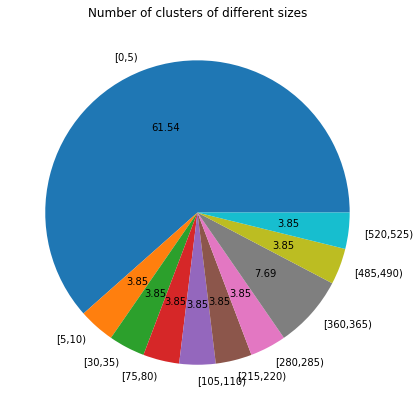

In [12]:
def cluster_sizes(model):
    labels = model.labels_
    sizes = {}
    for c in set(labels):
        sizes[c] = (labels == c).sum()
    return sizes

sizes = cluster_sizes(optimal_kmeans)
buckets = {}
for i in range(0,1000,5):
    tot = 0
    for v in sizes.values():
        tot += 1 if i <= v < i+5 else 0
    if tot > 0:
        buckets[i] = tot
        
plt.figure(figsize=(7, 7))
plt.pie(buckets.values(), labels=[f"[{b},{b+5})" for b in buckets.keys()],autopct='%.2f')
plt.title("Number of clusters of different sizes")
plt.show()

We find that most clusters are very small. 61% of clusters contain between 0 and 5 points only. We notice that the biggest cluster englobes over 500 points. This is a really unbalanced distribution of size and might suggest that our research papers contain a few really popular fields, as more smaller and less popular fields of study. The latter are the ones that have small clusters.

Next, we will look at some metrics to analyse our model:

In [13]:
silhouette_score = metrics.silhouette_score(X, optimal_kmeans.labels_)
davies_bouldin = metrics.davies_bouldin_score(X, optimal_kmeans.labels_)
print(f"The silhouette score for this model: {silhouette_score}")
print(f"The davies-bouldin index for this model: {davies_bouldin}")


The silhouette score for this model: -0.02457558282241621
The davies-bouldin index for this model: 3.0075508564596842


Here, we output a Silhouette score, and a Davies-Bouldin (DB) index for the model.

The DB index looks at the average 'similarity' between clusters. When talking about similar clusters i, and j, we compare the distance between them, and their sizes, s (average distances from points in a cluster to the center):$R_{i,j}= \frac{s_i+s_j}{d_{i,j}}$. 

A model with well-separated clusters will thus have a low DB index, 0 being the lowest possible score. A value of 3 means that we have points that will be within the range of other clusters and that they aren't as disjoint as we woud like.

The best silhouette score value is 1 and the worst value is -1, values near 0 indicating overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

The silhouette score takes into account two metrics: 

(a), the mean distance between a point, and all the others in the samen cluster.

(b), the average distance between a point and all the points in the nearest neighboring cluster.
$$ S = \frac{b-a}{max(b,a)} $$

Visibly, a score near 0 means that distance between a point and its neighbors is nearly equal to the distance to the points in its cluster, implying overlap.

The silhouette, DB, and CH scores all agree that our clusters aren't very separated.

## 1.2 Analysis of the citation graph (10 marks)
Use NetworkX to display the citation graph described by the adjacency matrix, A. Plot the degree distribution of the graph as a histogram. 

Compute the following three centrality measures for all the nodes of the graph: (i) degree; (ii) betweenness centrality; (iii) Pagerank. Study which nodes (if any) are highly central according to the three measures.

Using appropriate correlation plots (or otherwise), discuss the similarity between the node rankings according to the different centrality measures and explain why the centrality rankings might differ.

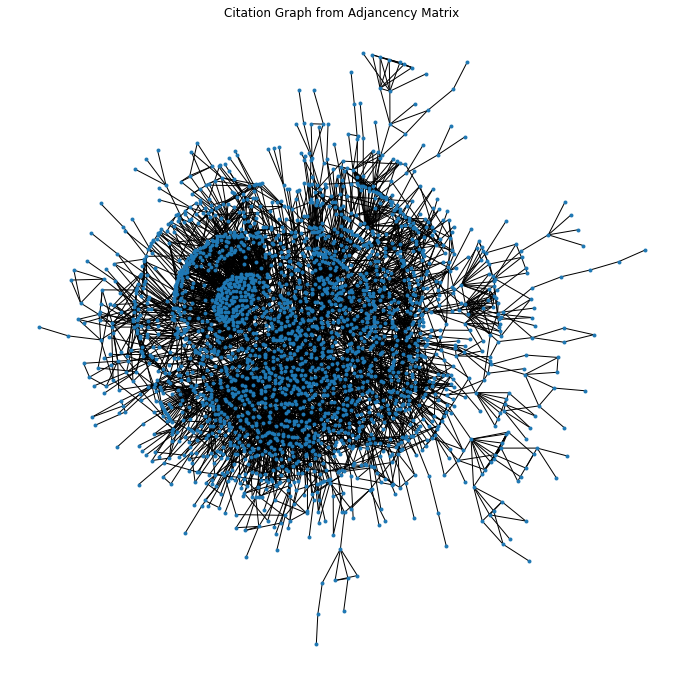

In [14]:
G = nx.from_numpy_matrix(adj_mat)

plt.figure(figsize=(12,12)) 
plt.title("Citation Graph from Adjancency Matrix")
nx.draw_kamada_kawai(G,node_size=15, with_labels=False, linewidths=0.05)
plt.show()

The max degree in the graph is: 168


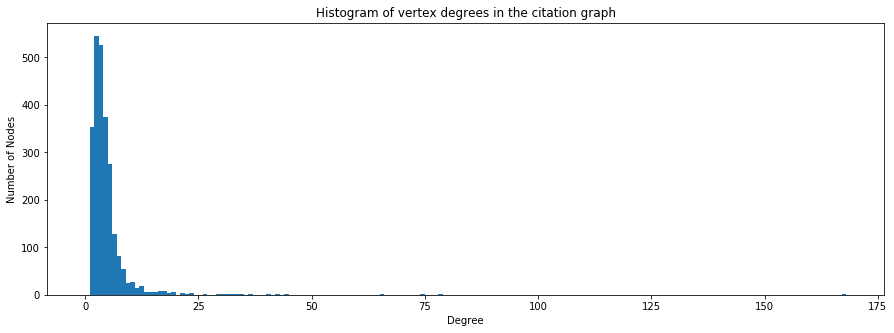

In [15]:
degrees = G.degree()

degrees_val = [d for (v,d) in degrees]
print(f"The max degree in the graph is: {max(degrees_val)}")
plt.figure(figsize=(15,5)) 
plt.title("Histogram of vertex degrees in the citation graph")
plt.hist(degrees_val, range(0, max(degrees_val)+1))
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

In [16]:
degrees = G.degree()
b_centrs = nx.betweenness_centrality(G)
pageranks = nx.pagerank(G)

In [17]:
measures = pd.DataFrame(degrees, columns=['node', 'degree'])
measures['between_centr']= measures['node'].map(b_centrs)
measures['pagerank']= measures['node'].map(pageranks)

def normalize(df, col):
    max_value = df[col].max()
    min_value = df[col].min()
    df[f"norm_{col}"] = (df[col] - min_value) / (max_value - min_value)
    return df

measures = normalize(measures, 'degree')
measures = normalize(measures, 'between_centr')
measures = normalize(measures, 'pagerank')
norms = measures[['norm_degree', 'norm_between_centr', 'norm_pagerank']]
measures['avg'] = norms.mean(axis=1)

top30 = measures.sort_values('avg', ascending=False).iloc[:30]
top30.head()

node  degree  between_centr  pagerank  norm_degree  norm_between_centr  \
1245  1245     168       0.276114  0.013302     1.000000            1.000000   
1846  1846      65       0.149763  0.005833     0.383234            0.542397   
1563  1563      74       0.101355  0.006811     0.437126            0.367076   
271    271      78       0.090707  0.005511     0.461078            0.328511   
1894  1894      40       0.106109  0.003471     0.233533            0.384295   

      norm_pagerank       avg  
1245       1.000000  1.000000  
1846       0.433407  0.453012  
1563       0.507653  0.437285  
271        0.409041  0.399543  
1894       0.254266  0.290698

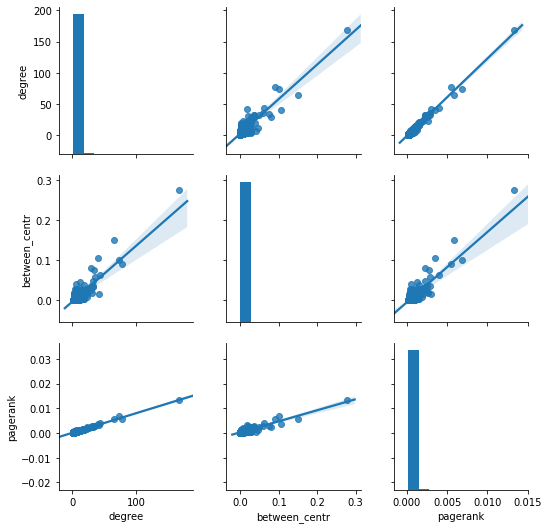

In [18]:
g = sbn.pairplot(measures[['degree', 'between_centr', 'pagerank']], kind='reg')

## 1.3 Community detection on the citation graph (10 marks)
Use the Clauset-Newman-Moore greedy modu- larity maximisation algorithm in Networkx to compute the optimal number of communities k* and the correspond- ing partition of the citation graph.

Plot the obtained clusters on the NetworkX graph you obtained in 1.2 by assigning different colours to the nodes in each community.

Study how the top 30 most central nodes according to degree and Pagerank computed in 1.2 are distributed across your k* communities. Explain your findings.

In [19]:
communities = nx.algorithms.community.greedy_modularity_communities(G)

In [20]:
print(f"The optimal value of k, k*, is {len(communities)}")

The optimal value of k, k*, is 29


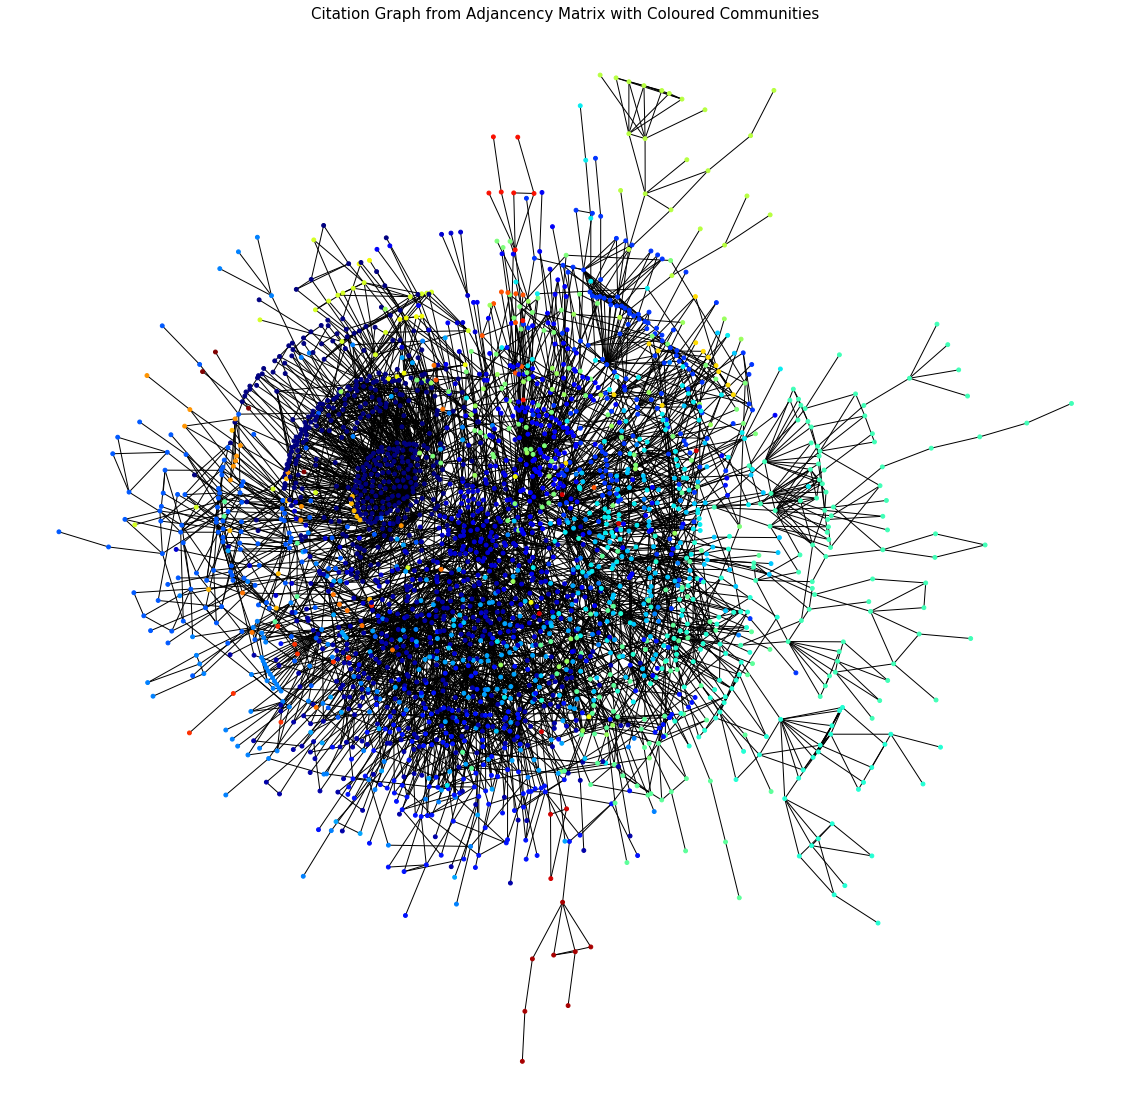

In [21]:
values = [0]* len(G.nodes())
for num, comm in enumerate(communities):
    for node in comm:
        values[node] = num

plt.figure(figsize=(20,20)) 
plt.title("Citation Graph from Adjancency Matrix with Coloured Communities", size=15)
cmap = plt.get_cmap('jet')
nx.draw_kamada_kawai(G, cmap=cmap, node_color=values, node_size=15,
                     with_labels=False)
plt.show()

In [22]:
comm_measures = measures
comm_measures['community'] = values

top30['community'] = [values[x] for x in top30['node']]

max_degrees = comm_measures.sort_values('degree', ascending=False)[['degree', 'community']][:30]
max_pagerank = comm_measures.sort_values('pagerank', ascending=False)[['pagerank', 'community']][:30]

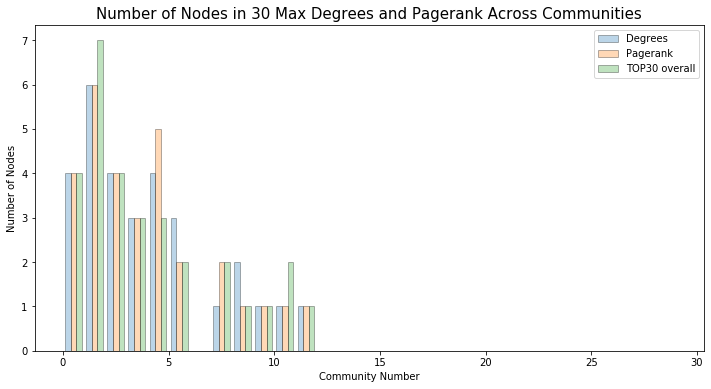

In [23]:
bins = range(0,30)
plt.figure(figsize=(12,6)) 
plt.title("Number of Nodes in 30 Max Degrees and Pagerank Across Communities", size=15)
plt.hist([max_degrees['community'], max_pagerank['community'], top30['community']], bins, 
         alpha=0.3, label=['Degrees', 'Pagerank', 'TOP30 overall'], edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Community Number')
plt.ylabel('Number of Nodes')
plt.show()

Text(0, 0.5, 'Size of Community')

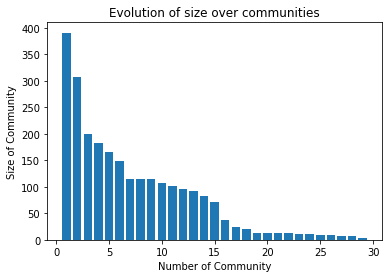

In [73]:
sizes = [len(comm) for comm in communities]

plt.bar(range(1,30),sizes)
plt.title("Evolution of size over communities")
plt.xlabel("Number of Community")
plt.ylabel("Size of Community")

Show that greedy will get large classes and then progressively smaller

Explain pagerank, explain degree, show that small sizes of classes -> small "ranks"

## 1.4 Compare feature and graph clusterings (10 marks)
Use Adjusted Mutual Information (AMI) and Adjusted Rand Index (ARI) to score how similar the optimal clusterings obtained in 1.1 and 1.3 are to each other.

Plot the clusters you obtained in 1.1 onto the NetworkX graph you generated in 1.2 so that you can compare visually the feature clusters in 1.1 to the graph-based communities in 1.3.

Based on the above, discuss the similarities and differences you observe. You can use other metrics or other visualisation methods to compare the two optimal clusterings at your discretion, explaining your choices.

In [25]:
greedy_community_labels = values
optimal_kmeans_labels = optimal_kmeans.labels_

AMI = metrics.adjusted_mutual_info_score(optimal_kmeans_labels, greedy_community_labels)
print(f"The AMI for the optimal KMeans and the Greedy Modularity Maximisation is {AMI}")

ARI = metrics.adjusted_rand_score(optimal_kmeans_labels, greedy_community_labels)
print(f"The ARI for the optimal KMeans and the Greedy Modularity Maximisation is {ARI}")

The AMI for the optimal KMeans and the Greedy Modularity Maximisation is 0.14529086433268382
The ARI for the optimal KMeans and the Greedy Modularity Maximisation is 0.08040060325273823


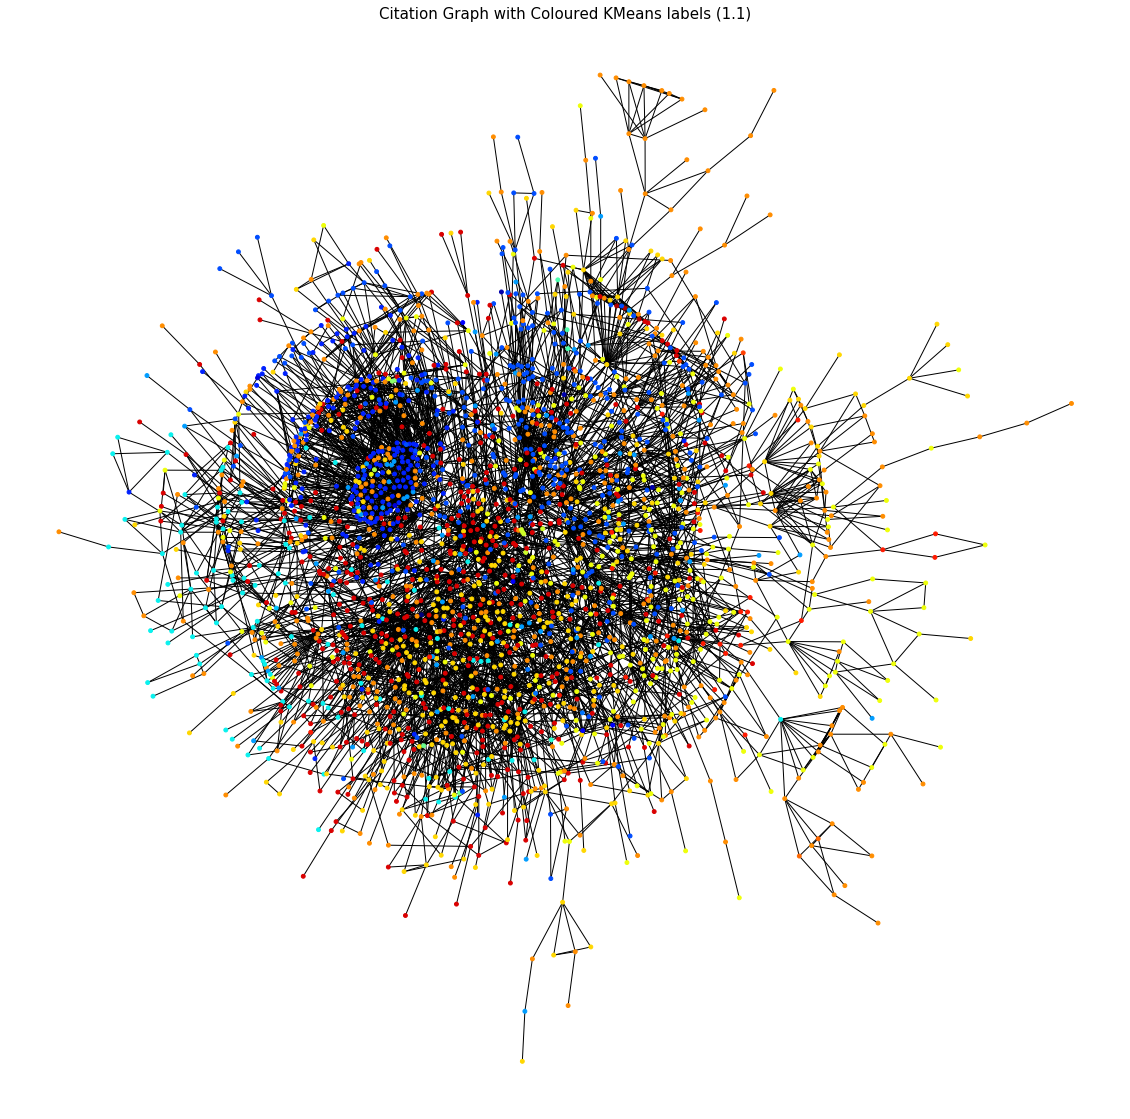

In [26]:
plt.figure(figsize=(20,20)) 
plt.title("Citation Graph with Coloured KMeans labels (1.1)", size=15)
cmap = plt.get_cmap('jet')
nx.draw_kamada_kawai(G, cmap=cmap, node_color=optimal_kmeans_labels, node_size=15,
                     with_labels=False)
plt.show()

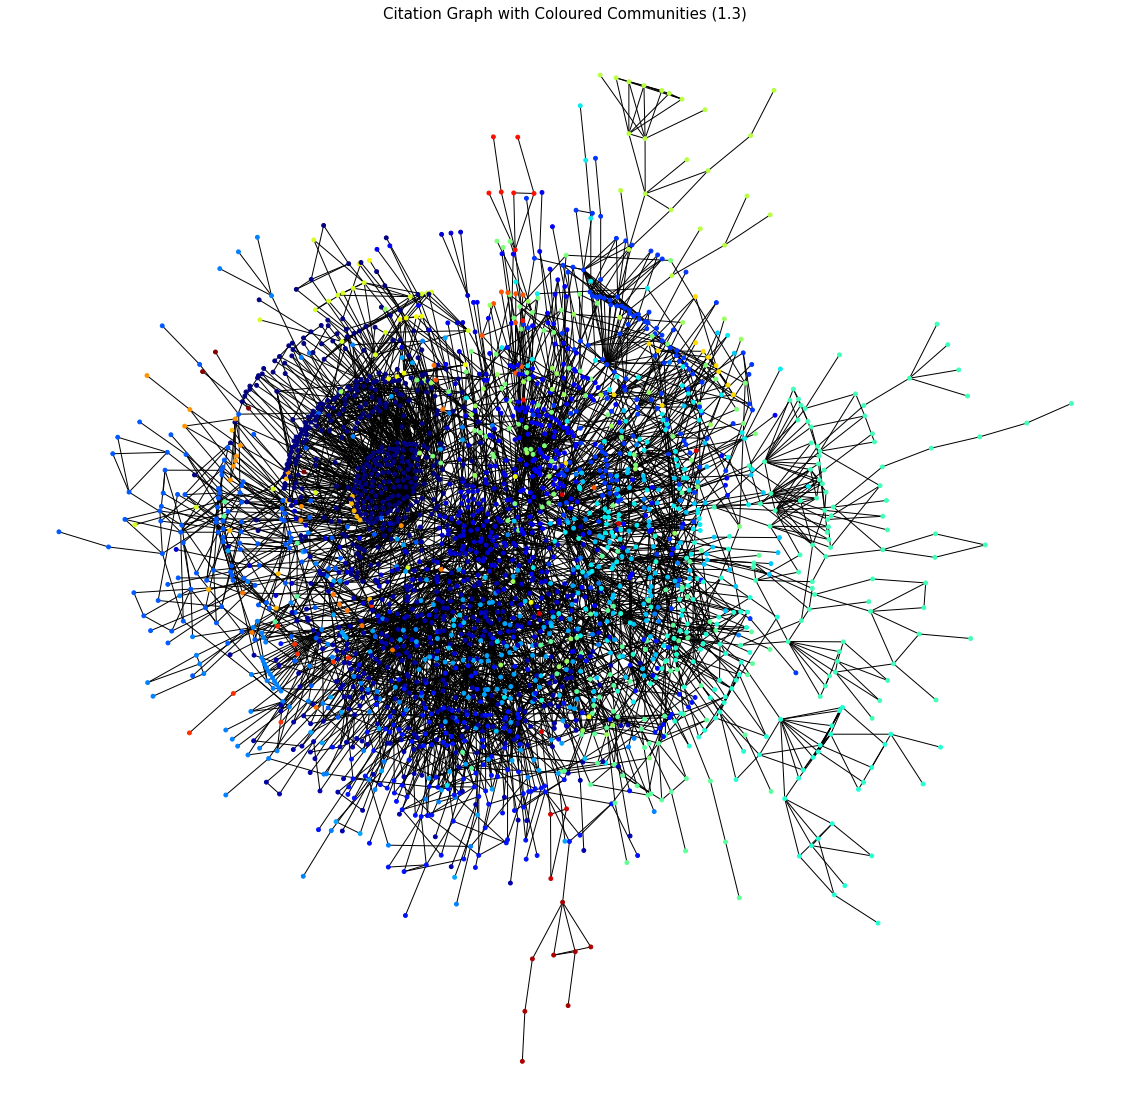

In [27]:
plt.figure(figsize=(20,20)) 
plt.title("Citation Graph with Coloured Communities (1.3)", size=15)
cmap = plt.get_cmap('jet')
nx.draw_kamada_kawai(G, cmap=cmap, node_color=values, node_size=15,
                     with_labels=False)
plt.show()

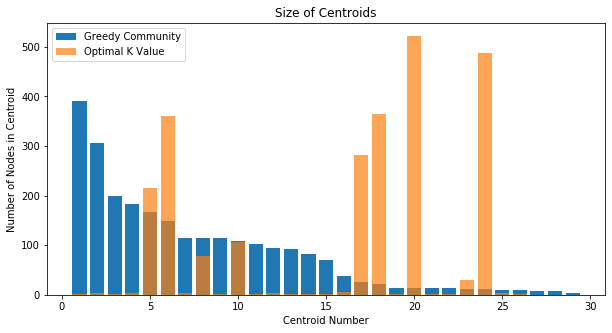

In [84]:

comm_sizes = [len(x) for x in communities]
optimal_kmeans_labels = list(optimal_kmeans_labels)
optimal_k_sizes = [optimal_kmeans_labels.count(c) for c in range(optimal)]

plt.figure(figsize=(10,5))
plt.title("Size of Centroids")
plt.bar(range(1,len(comm_sizes)+1), comm_sizes, label="Greedy Community")
plt.bar(range(1,len(optimal_k_sizes)+1), optimal_k_sizes, alpha=0.7,
       label="Optimal K Value")
plt.xlabel("Centroid Number")
plt.ylabel("Number of Nodes in Centroid")
plt.legend()
plt.show()


## 2.1 Unsupervised clustering of the image dataset (20 marks)
Use the k-means algorithm in sklearn in an unsupervised manner (i.e., without using any 'ground truth' labels) to cluster the Fashion-MNIST dataset (just the 'training' part) into k classes, for all values of k between k=2 and k=30. Give some thought to how to deal with the inherent randomness of the output of the k-means algorithm.

Do you find any evidence of the existence of 10 classes in the data? Support your explanation using some of the measures you discussed in Task 1.1, or otherwise using other unsupervised clustering methods described in class. Support your explanations with figures, computations and mathematical explanations.

Consider the k-means clustering you obtained for k=10. Visualise the centroid of each of the 10 clusters.

Use the k-means clustering with k=10 as a kNN classifier for the test set. Report its accuracy and any other quality measures of its performance.

In [29]:
mnist = fetch_openml('Fashion-MNIST', cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)
print(len(X_train), len(X_train[0]))

labels = {0:"T-shirt/top", 1:"Trousers", 2:"Pullover", 3:"Dress", 4:"Coat", 
          5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boots"}

60000 784


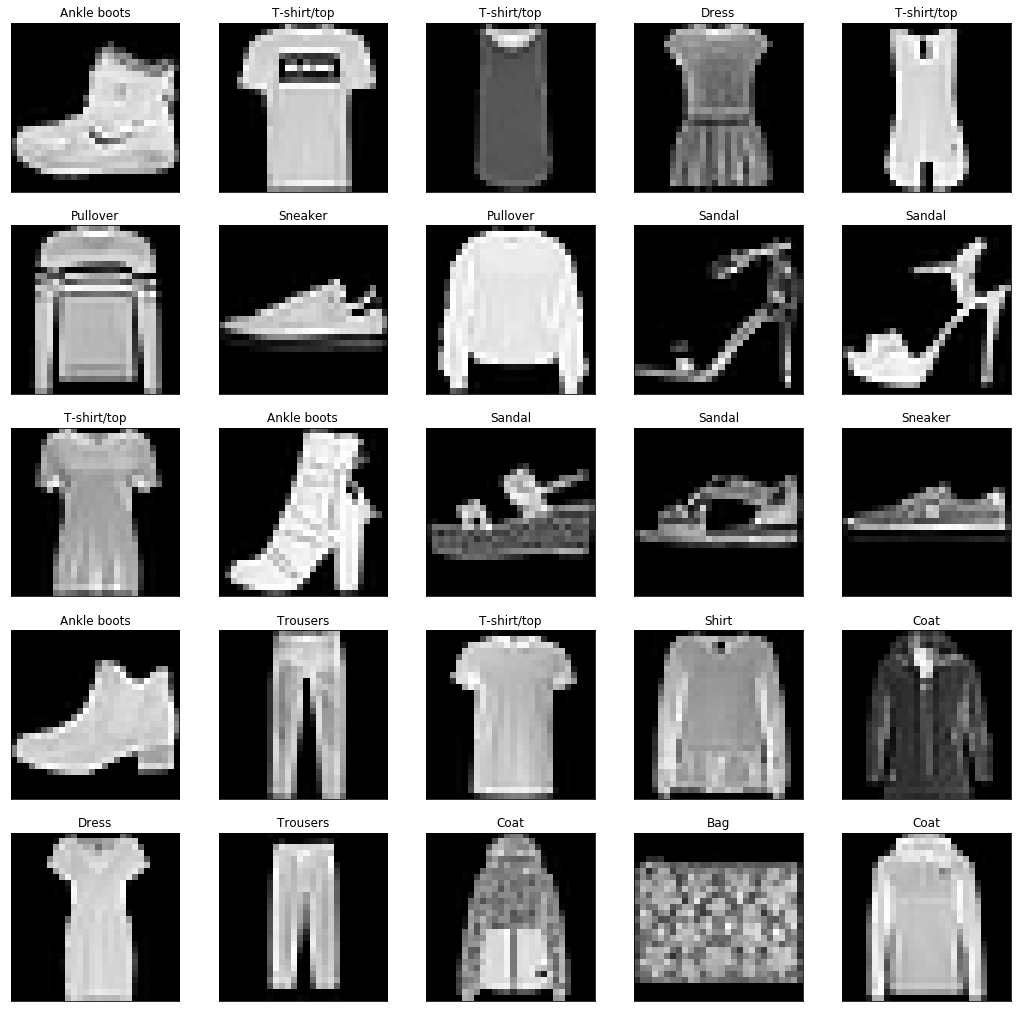

In [31]:
plt.figure(figsize=(18,18))
for i in range(25):
    plt.subplot(5, 5, i+1);
    fig = plt.imshow(X[i].reshape(28, 28), label=y[i],
                  cmap = plt.cm.gray)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(labels[y[i]])

In [32]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled  = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

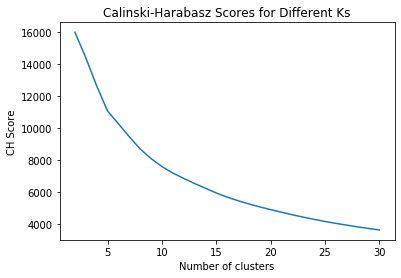

In [94]:
avg_f_chs = []
avg_bds = []
avg_sils= []

for i in range(2, 31):
    chs = []
    bds = []
    sils= []
    for trial in range(10):
        kmeans = KMeans(n_clusters=i, n_jobs=-1)
        kmeans.fit(X_train)
        labels = kmeans.labels_
        chs.append(metrics.calinski_harabasz_score(X_train, labels))
        bds.append(metrics.davies_bouldin_score(X_train, labels))
        sils.append(metrics.silhouette_score(X_train, labels))
    avg_f_chs.append(np.mean(chs))
    avg_bds.append(np.mean(bds))
    avg_sils.append(np.mean(sils))
        
plt.plot(range(2, 31), avg_f_chs)
plt.title('Calinski-Harabasz Scores for Different Ks')
plt.xlabel('Number of clusters')
plt.ylabel('CH Score')
plt.show()

In [95]:
print(avg_f_chs)
print(avg_bds)
print(avg_sils)

[16005.327960720335, 14411.900670379375, 12653.932497312613, 11083.428390039406, 10285.46935477605, 9472.732857633648, 8711.26439075224, 8111.642510371709, 7609.8812613037035, 7205.83014632338, 6870.363955597853, 6552.4699213484, 6253.490830158734, 5960.578499589784, 5699.249923009142, 5474.810806326984, 5273.348344678823, 5087.765492412157, 4918.1739489489955, 4754.866035773036, 4595.979502340646, 4447.172282611816, 4307.249384500904, 4178.140853396664, 4058.790852446274, 3947.7924712019367, 3838.7559923634826, 3740.2704935927295, 3648.3030483471084]
[1.8868486456188975, 1.7232798942786096, 1.801603289286824, 1.9289173029656517, 1.8343314958529806, 1.9151528214513784, 1.9197574559071733, 1.823470516627447, 1.8637628589157824, 1.9456861874763764, 2.0064272664977016, 2.018624883007883, 2.0724038789715573, 2.1059474338202158, 2.1037194605735623, 2.102584980295797, 2.102133179748207, 2.1005186806111196, 2.1107446609196727, 2.132064050047703, 2.1590871370008555, 2.1791747763621823, 2.19047

# TODO : FIND evidence of k=10 (graph and elbow? and scores found above)

In [290]:
k10 = KMeans(n_clusters=10, n_jobs=-1)
k10.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

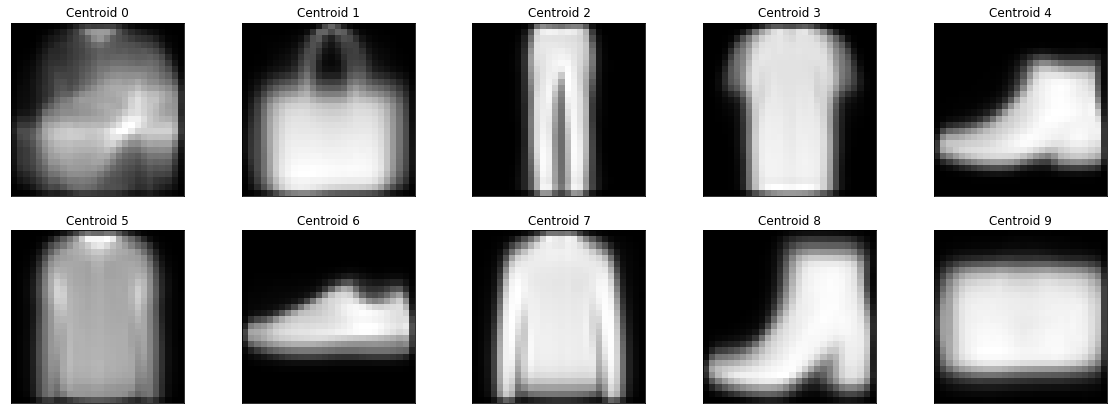

In [292]:
plt.figure(figsize=(20,7))
plt.title("Visualisation of the centroids for our k=10 kNN classifier")
for i in range(10):
    plt.subplot(2, 5, i+1);
    plt.title(f"Centroid {i}")
    fig = plt.imshow(k10.cluster_centers_[i].reshape(28, 28),
                  cmap = plt.cm.gray, interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [359]:
#Matching centroids to correct labels
#create a mapping between label x and centroid y
#Hungarian Algorithm to solve optimal assignment problem
def cluster_assignment(y_true, y_pred):
    w = np.zeros((10, 10))
    for i in range(len(y_pred)):
        w[y_pred[i], y_true[i]] += 1
        
    assignment = linear_assignment(w.max() - w)
    return assignment

In [381]:
#using k10 check accuracy and other metrics on test set
predicted = k10.predict(X_test)
assignment = cluster_assignment(y_test, predicted)
print("This is the optimal mapping between centroids and labels")
print("Centroid  Label")
for c in assignment:
    print(f"    {c[0]} ---> {c[1]}")
    
predicted_labels = [assignment[pred][1] for pred in predicted]

This is the optimal mapping between centroids and labels
Centroid  Label
    0 ---> 5
    1 ---> 8
    2 ---> 1
    3 ---> 0
    4 ---> 9
    5 ---> 6
    6 ---> 7
    7 ---> 4
    8 ---> 3
    9 ---> 2


In [39]:
def draw_cm(preds, true_ys):

    plt.figure(figsize=(12,10))
    sbn.heatmap(confusion_matrix(preds, true_ys), annot = True, fmt='g')

    #Matplotlib bug causing a cutoff on top and bottom of heatmap rendition
    bottom, top = plt.ylim()
    plt.ylim(bottom + 0.5, top - 0.5)

    plt.show()

Confusion matrix for our kNN classifier


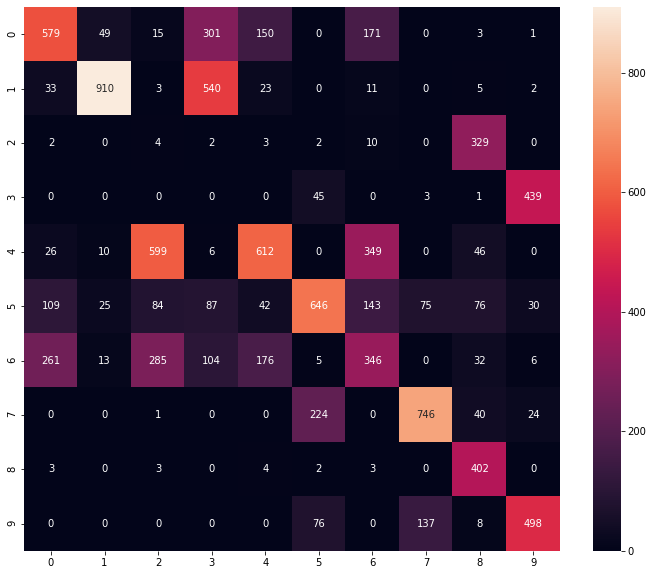

In [383]:
print("Confusion matrix for our kNN classifier") 
draw_cm(predicted_labels, y_test)

In [384]:
print(classification_report(predicted_labels, y_test))

              precision    recall  f1-score   support

           0       0.57      0.46      0.51      1269
           1       0.90      0.60      0.72      1527
           2       0.00      0.01      0.01       352
           3       0.00      0.00      0.00       488
           4       0.61      0.37      0.46      1648
           5       0.65      0.49      0.56      1317
           6       0.33      0.28      0.31      1228
           7       0.78      0.72      0.75      1035
           8       0.43      0.96      0.59       417
           9       0.50      0.69      0.58       719

    accuracy                           0.47     10000
   macro avg       0.48      0.46      0.45     10000
weighted avg       0.57      0.47      0.50     10000



## 2.2 Supervised classification of the training set (25 marks)
### 2.2.1 MLP neural network supervised classification: 
Using PyTorch, implement a multilayer perceptron (MLP) to classify the images of the dataset into the 10 classes. For this task, you will need to vectorise your images so that they can be used as inputs.

Setup of the network: Your MLP will have a number of input nodes equal to the number of pixels in each image, three hidden layers, each with 100 nodes, and an output layer with 10 nodes corresponding to the num- ber of classes. You should use ReLU as your activation function with no dropout.

For the training, you should use a negative log-likelihood loss, a learning rate of 0.005, and stochastic gradi- ent descent (SGD) as the optimisation method. You should train in batches of 128 images for 30 epochs. Note: If using Google Colab, make sure you use its GPUs by selecting in the top menu 'Edit > Notebook set- tings > Hardware accelerator > GPU'.
Compute the accuracy of this MLP classifier on the test set and report any other quality measures of its per- formance. No optimisation of hyperparameters is necessary.

In [33]:
train_tensor = TensorDataset(torch.tensor(X_train), torch.tensor(y_train)) 
test_tensor = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [54]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, f=F.relu):
        super(MLP, self).__init__()
        self.layer_in = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_out = nn.Linear(hidden_dim, output_dim)
        self.f = f

    def forward(self, x):
        out = self.f(self.layer_in(x))
        out = self.f(self.layer1(out))
        out = self.f(self.layer2(out))
        out = self.f(self.layer3(out))
        out = nn.LogSoftmax(dim=1)(self.layer_out(out))

        return out

In [86]:
def train_network(network=MLP(input_dim= 28*28, hidden_dim = 100, output_dim=10, f=F.relu), 
                  batch_size = 128, learning_rate=0.005, num_epochs=30, graph=True,  train_tensor=train_tensor):

    #Prepare data
    train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size)
    
    criterion = nn.NLLLoss()
    optimiser = torch.optim.SGD(network.parameters(), lr=learning_rate)
    
    #Train net
    loss_values = []
    total_step = len(train_loader)

    for _ in range(num_epochs):

        network.train()
        train_loss = 0.0

        for Xs, ys in train_loader:
            
            # forward pass
            outputs = network(Xs)
            loss = criterion(outputs, ys)
            
            # backward and optimise
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            train_loss += loss.item()
        loss_values.append(train_loss / total_step)
    
    if graph:
        plt.figure(figsize=(12,8))
        plt.title('Training Loss over Epochs')
        plt.ylabel('Training Loss', fontsize=20)
        plt.xlabel('Epoch', fontsize=20)
        plt.plot(range(len(loss_values)), loss_values)
        plt.show()
     
    return network, loss_values

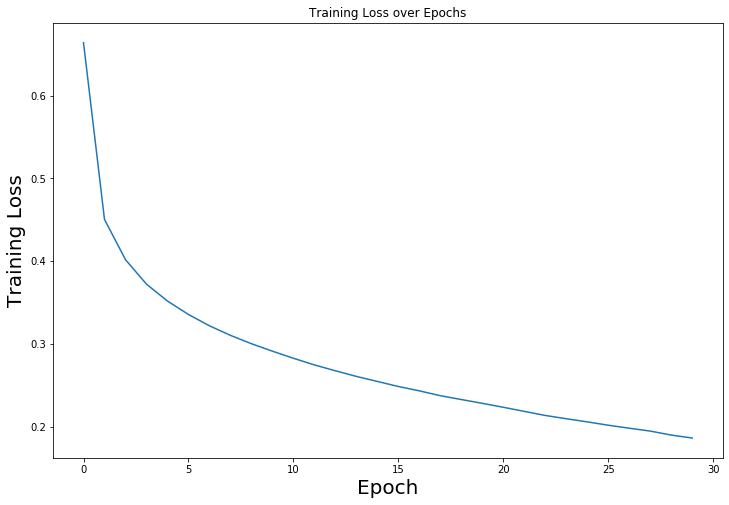

In [87]:
mlp, mlp_losses = train_network()

In [57]:
def net_eval(net, test_loader): 
    net.eval()
    preds = []
    true_ys = []
    for Xs, ys in test_loader:
        outputs = net(Xs)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.tolist())
        true_ys.extend(ys.tolist())
        
    return preds, true_ys

Confusion matrix for our net


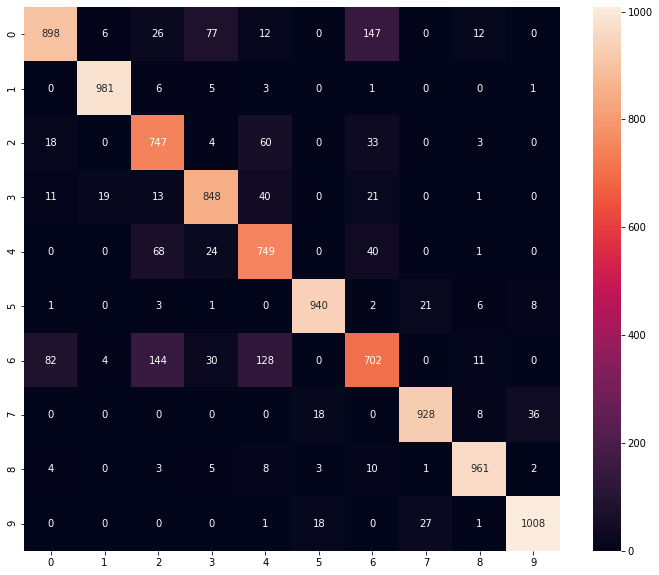

In [58]:
#compute accuracy on test set and otyher metrics
test_loader = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=128, shuffle=False)

preds, true_ys = net_eval(mlp, test_loader)

print("Confusion matrix for our net") 
draw_cm(preds, true_ys)

In [59]:
print(classification_report(preds, true_ys))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1178
           1       0.97      0.98      0.98       997
           2       0.74      0.86      0.80       865
           3       0.85      0.89      0.87       953
           4       0.75      0.85      0.80       882
           5       0.96      0.96      0.96       982
           6       0.73      0.64      0.68      1101
           7       0.95      0.94      0.94       990
           8       0.96      0.96      0.96       997
           9       0.96      0.96      0.96      1055

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### 2.2.2 Convolutional neural network (CNN) supervised classification
Using PyTorch, build a small CNN to classify the images of the dataset into the 10 classes.

Setup of the network: Your CNN should have the following architecture:
![222archi](222archi.png)


You should choose ReLU as the activation functions, reduce the dimensionality of the feature maps by a sub- sampling layer where the highest value in each subsampled feature map is chosen, implement a stride of 2 into these pooling layers, and have a kernel size of 5 in all convolutional layers. The stride and the dilation in the convolutional layers should be both 1. All other hyperparameters and options remain as in 2.2.1.
  
Note: If using Google Colab, make sure you use its GPUs by selecting in the top menu 'Edit > Notebook set- tings > Hardware accelerator > GPU'.

Compute the accuracy of this CNN classifier on the test set and report any other quality measures of its per- formance.

In [42]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, dilation=1)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, dilation=1)
        self.c5 = nn.Linear(in_features=256, out_features=120)
        self.f6 = nn.Linear(in_features=120, out_features=84)
        self.out = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, input):
        #C1 and S2
        out = F.relu(self.c1(input))
        out = F.max_pool2d(out, kernel_size=2, stride=2)
        
        #C3 and S4
        out = F.relu(self.c3(out))
        out = F.max_pool2d(out, kernel_size=2, stride=2)
        
        #C5 and F6
        out = out.reshape(-1, 256)
        out = F.relu(self.c5(out))
        out = F.relu(self.f6(out))
        
        #LogSoftmax for NLLLoss
        out = self.out(out)
        out = nn.LogSoftmax(dim=1)(out)
        
        return out

In [43]:
train_tensor_CNN = TensorDataset(torch.tensor(X_train_scaled.reshape(60000, 1, 28, 28)), torch.tensor(y_train))
test_tensor_CNN = TensorDataset(torch.tensor(X_test_scaled.reshape(10000, 1, 28, 28)), torch.tensor(y_test))

In [88]:
cnn, cnn_losses = train_network(network=CNN(), train_tensor=train_tensor_CNN, graph=False)

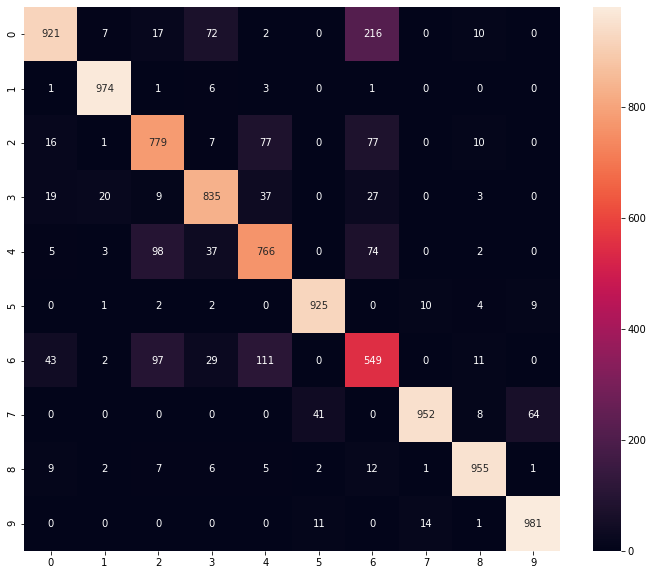

In [45]:
test_loader_CNN = torch.utils.data.DataLoader(dataset=test_tensor_CNN, batch_size=128, shuffle=False)

preds_CNN, true_ys_CNN = net_eval(cnn, test_loader_CNN)
draw_cm(preds_CNN, true_ys_CNN)

In [46]:
print(classification_report(preds_CNN, true_ys_CNN))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1245
           1       0.96      0.99      0.98       986
           2       0.77      0.81      0.79       967
           3       0.84      0.88      0.86       950
           4       0.77      0.78      0.77       985
           5       0.94      0.97      0.96       953
           6       0.57      0.65      0.61       842
           7       0.97      0.89      0.93      1065
           8       0.95      0.95      0.95      1000
           9       0.93      0.97      0.95      1007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



### 2.2.3 Comparisons of the classifiers
Compare the performance of the CNN and MLP classifiers focussing in particular on the difference in the number of parameters in both models. Explain the observed difference in performance given the different operations on the data carried out by the MLP and CNN models.
Compare the performance of both supervised classifiers to the k-NN classifier obtained in 2.1 from the unsu- pervised k-means clustering. Discuss the outcomes given the distinct approaches used in supervised and unsupervised learning.

Using 5-fold cross-validation on the training set, optimise the CNN architecture to increase its accuracy above 90%. You might want to try adding hidden layers, changing the activation function, or any other method you believe could increase the accuracy. Explain your choices and why these changes result in an improvement.

# TODO

In [61]:
mlp_params = np.sum([p.numel() for p in mlp.parameters()])
print(mlp_params)
cnn_params = np.sum([p.numel() for p in cnn.parameters()])
print(cnn_params)

109810
44426


Summing up the neurons in the MLP:

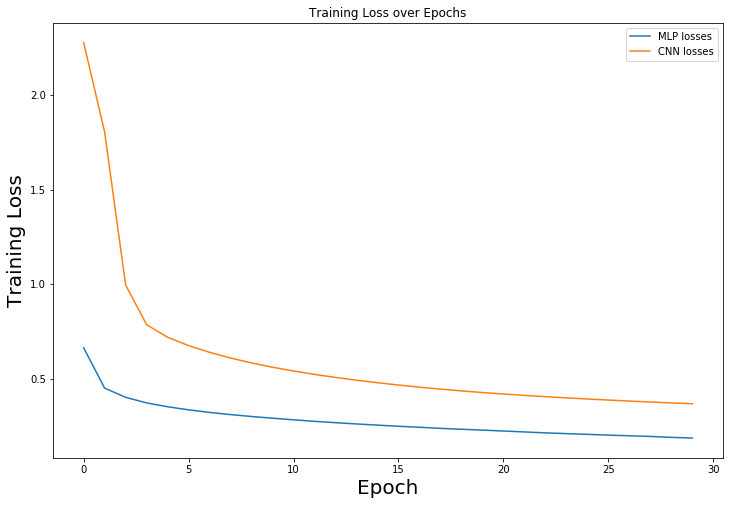

In [89]:
plt.figure(figsize=(12,8))
plt.title('Training Loss over Epochs')
plt.ylabel('Training Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.plot(range(len(mlp_losses)), mlp_losses, label="MLP losses")
plt.plot(range(len(cnn_losses)), cnn_losses, label="CNN losses")
plt.legend()
plt.show()

## Task 3: Poster (10 marks)
Prepare a pdf file with a poster to illustrate your work and findings for either Task 1 or Task 2. You are free to choose the format of your poster. The poster should contain a concise description of the data and the problem; a summary of the methods used, and a compilation of your findings and conclusions.

The poster should be concise but clear; should not contain large amounts of text; and use clearly labelled figures and tables obtained with your Python scripts. Keep to message but be clear about your conclusions.

Your target audience would be, e.g., a manager working for Nature Publishing Group (for Task 1) or a manager working for Zara or Uniqlo (for Task 2), looking to hire a data scientist to join their company. There is more guidance on the poster at the end of the Coursework.

## 4.1 Comparing PCA and NMF dimensionality reduction
Use principal component analysis (PCA) and non- negative matrix factorisation (NMF) to reduce the dimensionality of the Fashion-MNIST dataset (just the 'training' part) to the top 10 'components'. For each of the two methods, visualise each of the 10 components and study quantitatively how they are related to the 10 classes in the data. Use your computations to explain the differ- ences between the PCA and NMF representations in terms of the sparsity of the corresponding components and the correspondence of the components to visual features (see NMF original paper by Lee and Seung).

### PCA
https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c


This is
because PCA allows the entries of Wand H to be of arbitrary sign.
As the eigenfaces are used in linear combinations that generally
involve complex cancellations between positive and negative
numbers, many individual eigenfaces lack intuitive meaning.

In [94]:
pca = PCA(n_components=10).fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)

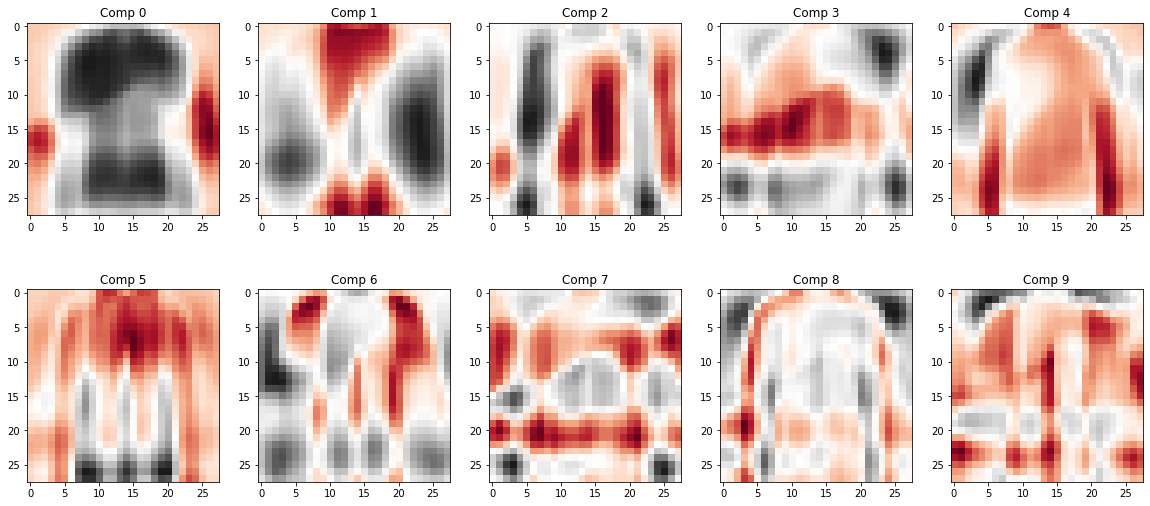

In [158]:
H = pca.components_

plt.figure(figsize=(20,9))

for i in range(10):
    comp = H[i]
    plt.subplot(2, 5, i+1)
    cmap = plt.cm.RdGy
    plt.title(f'Comp {i}')
    plt.imshow(comp.reshape(28, 28), cmap, interpolation='nearest')


https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21

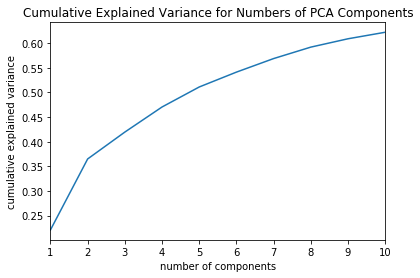

In [61]:
plt.plot(range(1,11), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance for Numbers of PCA Components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim((1,10))
plt.show()

In [106]:
X_pca = pd.DataFrame(X_pca)
for i in range(10):
    X_pca = X_pca.rename(columns={i: f"Comp {i}"})
X_pca['label'] = y_train
X_pca

Comp 0     Comp 1     Comp 2     Comp 3    Comp 4     Comp 5  \
0      23.386110   7.087563   5.565238  -8.427908 -7.635415  -5.327686   
1      -5.895489  -7.572090   6.583915  11.306776 -3.736989  16.546989   
2       5.309990 -16.947491 -11.563787  -2.649443 -1.582943  -7.395647   
3     -14.474453   9.970125  -1.017350 -14.064631  1.779147   4.644151   
4      -6.239171  -9.884529  -0.184567  -0.631398 -1.089369   0.701237   
...          ...        ...        ...        ...       ...        ...   
59995 -16.619694   6.744232   0.909918  -8.237674 -1.143595   2.927320   
59996  12.736378  -7.455631  -1.917719   3.649008  8.031244   2.300038   
59997  23.751902   9.540892   1.666385   5.231922  0.485423  -3.575998   
59998 -16.946165  -6.774004  14.264639   4.784925 -0.882493  -2.258455   
59999  -0.843125  -1.500025   5.863211   2.656330  1.105900   2.508984   

         Comp 6     Comp 7    Comp 8    Comp 9  label  
0     -2.238268  -3.744098  3.982989  0.430203      4  
1      6.063694  -6.116467  0.247500  3.395154      8  
2      5.169402   3.273090 -0.996927  2.563565      1  
3     -1.976943  10.128230  1.875796 -0.570978      7  
4      2.026977  -2.373279  0.639657 -0.498878      4  
...         ...        ...       ...       ...    ...  
59995 -4.143447   2.656511  0.221951  3.218767      5  
59996 -8.343300  -1.088675 -2.752751 -4.100410      0  
59997  0.359595  11.071993 -7.791090 -0.054218      6  
59998  0.364762  -4.454075  2.464791  0.017300      4  
59999 -1.985574  -0.295718 -2.951631  2.118093      6  

[60000 rows x 11 columns]

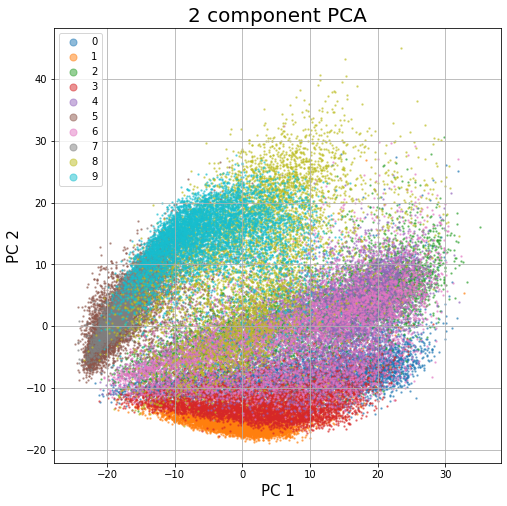

In [113]:
fig = plt.figure(figsize = (8,8))
plt.title('2 component PCA', fontsize = 20)

for label in set(y_train):
    labeled = X_pca[X_pca['label'] == label]
    plt.scatter(labeled['Comp 0'], labeled['Comp 1'], s=2, label=str(label), alpha=0.5)
    
plt.xlabel('PC 1', fontsize = 15)
plt.ylabel('PC 2', fontsize = 15)
plt.legend(markerscale=5)
plt.grid()

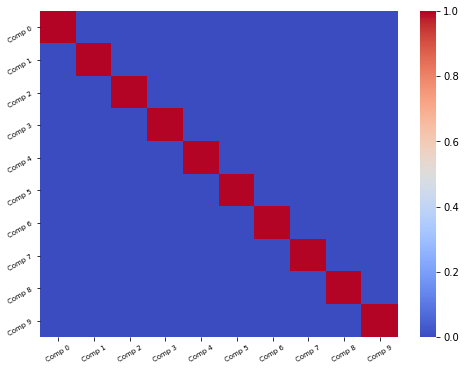

In [107]:
plt.figure(figsize=(8,6))

s=sbn.heatmap(X_pca.iloc[:,:-1].corr(),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)

plt.show()

## NMF

NMF does not allow negative entries in the matrix factors Wand
H. Unlike the unary constraint of VQ, these non-negativity constraints
permit the combination of multiple basis images to represent
a face. But only additive combinations are allowed, because the
non-zero elements of Wand H are all positive. In contrast to PCA,
no subtractions can occur. For these reasons, the non-negativity
constraints are compatible with the intuitive notion of combining
parts to form a whole, which is how NMF learns a parts-based
representation.

the NMF basis and encodings contain
a large fraction of vanishing coefficients, so both the basis images
and image encodings are sparse.
This
results in a sparsely distributed image encoding, in contrast to the
unary encoding of VQ and the fully distributed PCA encoding

an image pixel Vim is generated by adding Poisson
noise to the product (WH)im. The objective function in equation (2)
is then related to the likelihood of generating the images in V from
the basis Wand encodings H

In [77]:
#Non negative inputs
nmf = NMF(n_components=10).fit(X_train)
X_nmf = nmf.transform(X_train)

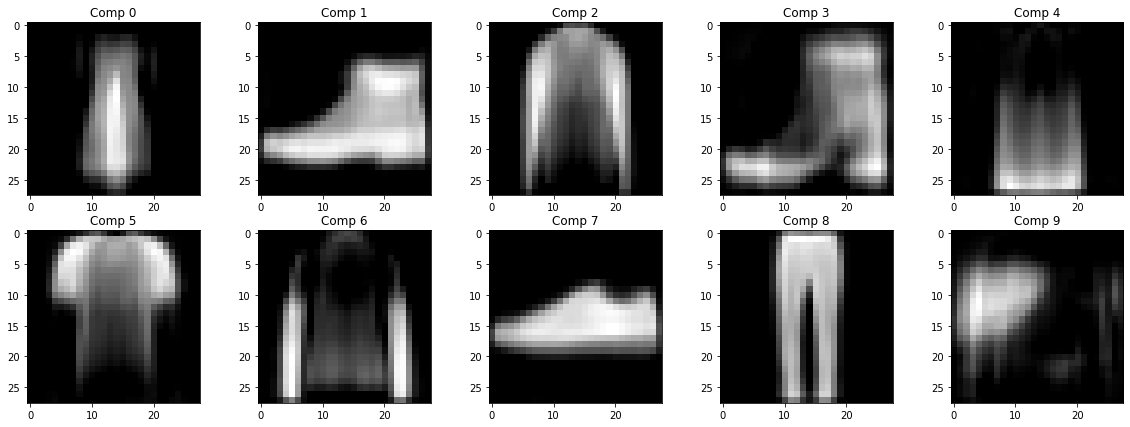

In [103]:
H = nmf.components_

plt.figure(figsize=(20,7))
for i in range(10):
    plt.subplot(2, 5, i+1);
    plt.title(f'Comp {i}')
    plt.imshow(H[i].reshape(28, 28),
                  cmap = plt.cm.gray, interpolation='nearest');


In [100]:
X_nmf = pd.DataFrame(X_nmf)
for i in range(10):
    X_nmf = X_nmf.rename(columns={i: f"Comp {i}"})
X_nmf['label'] = y_train

Comp 0    Comp 1    Comp 2    Comp 3    Comp 4    Comp 5    Comp 6  \
0      2.361427  0.406906  3.987957  0.000000  0.288271  1.222427  2.344606   
1      0.000000  0.000000  0.000000  0.094264  5.125122  0.000000  1.233822   
2      1.726902  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  0.100412  0.000000  0.000000  0.042590  0.000000  0.186905   
4      1.126686  0.000000  0.812489  0.000000  1.028495  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
59995  0.000000  1.277431  0.216961  0.000000  0.000000  0.000000  0.056783   
59996  1.231971  0.267736  0.000000  0.000000  3.486408  3.608729  0.000000   
59997  1.729112  0.247597  0.000000  1.992095  1.873984  3.223488  2.195734   
59998  0.000000  0.000000  1.422641  0.000000  0.000000  0.000000  0.504713   
59999  0.179941  0.621187  0.269094  0.000000  2.248494  1.371632  1.223544   

          Comp 7    Comp 8    Comp 9  label  
0       0.105348  0.534263  0.000000      4  
1       0.000000  0.167537  0.000000      8  
2       0.000000  7.054287  0.000000      1  
3      10.526116  0.000000  0.367078      7  
4       0.469235  2.109691  0.000000      4  
...          ...       ...       ...    ...  
59995   6.507829  0.000000  0.000000      5  
59996   0.031261  1.231843  0.320752      0  
59997   0.646267  1.399303  1.102874      6  
59998   0.000000  0.000000  0.000000      4  
59999   1.002237  0.721488  0.274217      6  

[60000 rows x 11 columns]

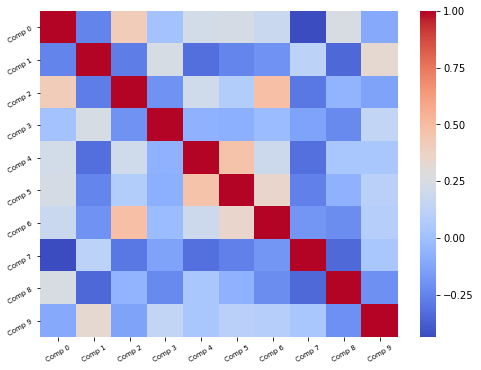

In [104]:
plt.figure(figsize=(8,6))

s=sbn.heatmap(X_nmf.iloc[:,:-1].corr(),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)

plt.show()

## 4.2 Latent Dirichlet Allocation (LDA) applied to images
Latent Dirichlet allocation (LDA) is a method intro- duced by Blei, Ng and Jordan, which is widely used in Natural Language Processing (NLP) to analyse collec- tions of text documents (like the one you were given in Task 1) to group documents into 'topics' according to their similarity. You should read the description of LDA in the literature.

Making the following analogies (document→image, word→pixel), apply LDA to the Fashion-MNIST dataset (just the 'training' part) in order to find 10 'topics' corresponding to groups of images that display high similarities.

Visualise each of the centroids of the 10 groups you found using LDA and compare them with those found in 4.1 and 2.1. Would you expect LDA to work on this problem? Give some reasons based on your reading of the method.

In [109]:
#Non negative inputs
lda = LatentDirichletAllocation(n_components=10).fit(X_train)
X_lda = lda.transform(X_train)

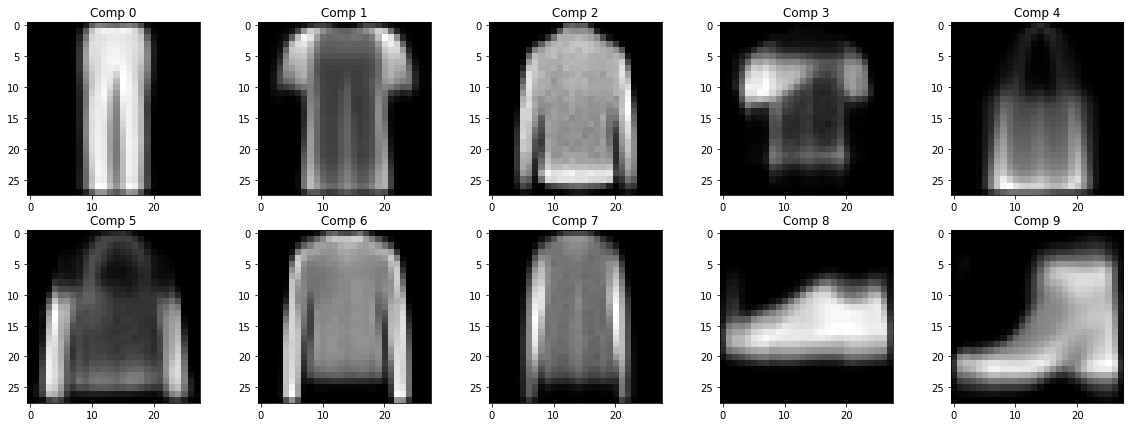

In [110]:
H = lda.components_

plt.figure(figsize=(20,7))
for i in range(10):
    plt.subplot(2, 5, i+1);
    plt.title(f'Comp {i}')
    plt.imshow(H[i].reshape(28, 28),
                  cmap = plt.cm.gray, interpolation='nearest');

Wouldn't expect it to be successful because you can't extract asmuich 'meaning' from one color gradient (black->white) than words.



you attribute equal importance to every pixel, even the dark corners and uninteresting parts of the iamge. This is bad ebcause with LDA you're looking at topics.

Better would be to use NMF on images to extract features, and then LDA